In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')

from astroLuSt.preprocessing import binning as alpb
from astroLuSt.preprocessing import dataseries_manipulation as alpdm
from astroLuSt.preprocessing import periodanalysis as alppe
from astroLuSt.preprocessing import outlierremoval as alpo
from astroLuSt.preprocessing import photometry as alpph
from astroLuSt.synthetics import images as alsi

np.random.seed(0)

import importlib
importlib.reload(alpb)
importlib.reload(alpdm)
importlib.reload(alpo)
importlib.reload(alppe)
importlib.reload(alpph)
importlib.reload(alsi)

#style for plotting
plt.style.use('astroLuSt.styles.LuSt_style')

# Generate (periodic) time-series

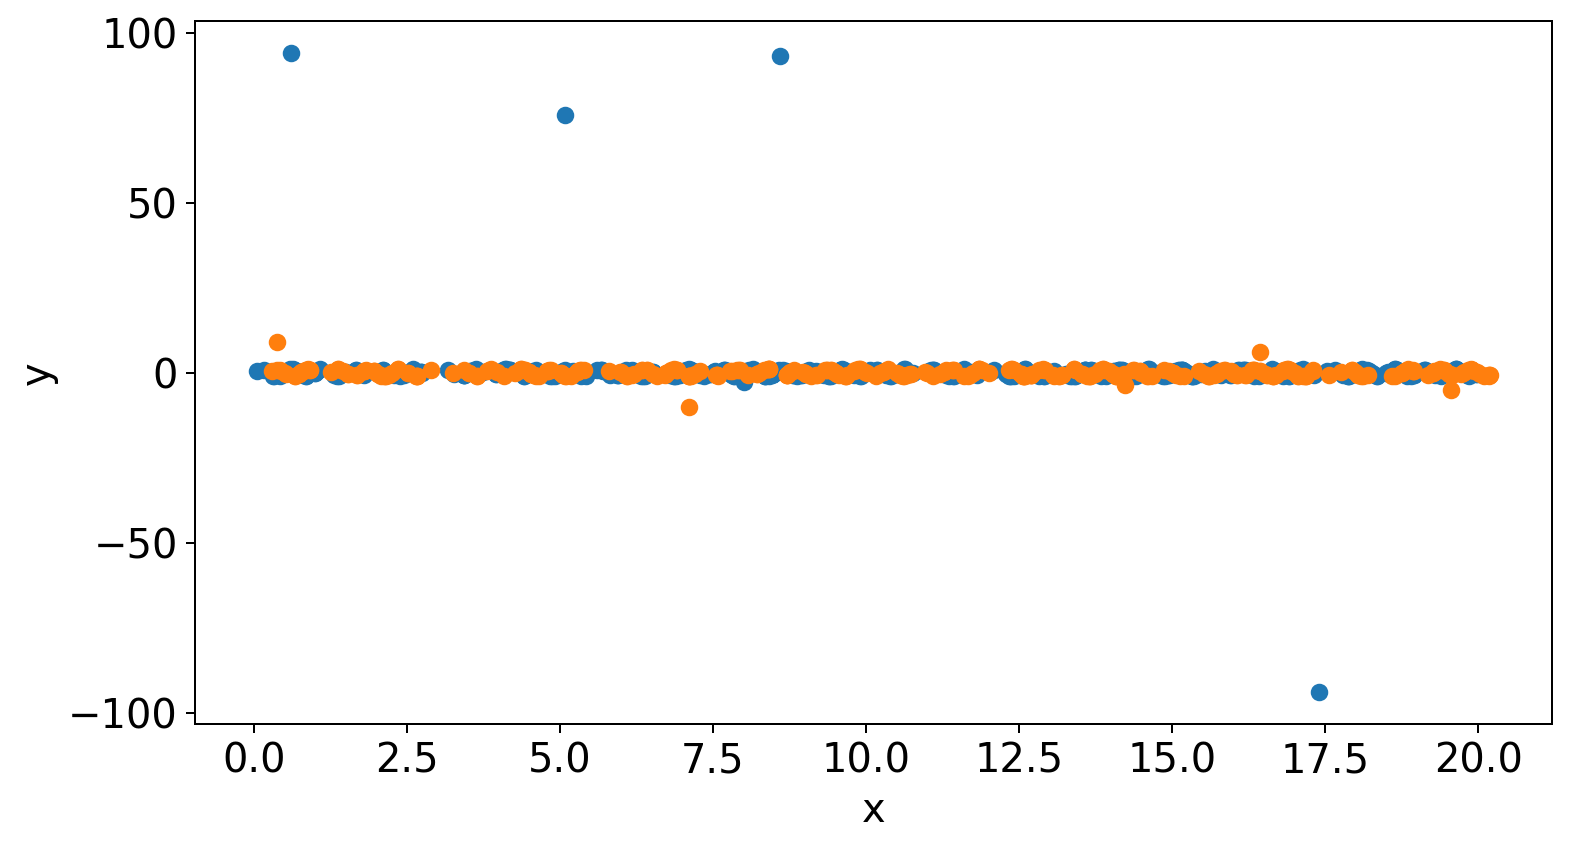

In [14]:
p = 0.5
x = np.linspace(0,20,1000)
x += np.random.normal(size=x.shape)*0.05
y = np.sin(x*2*np.pi/0.5)  + np.random.normal(size=x.shape)*0.05

#randomly sample from x and y
randidxs1 = np.random.choice(np.arange(0, x.shape[0], 1), size=400)
randidxs2 = np.random.choice(np.arange(0, x.shape[0], 1), size=400)


x1 = x[randidxs1]
y1 = y[randidxs1]

x2 = x[randidxs2]+p/2
y2 = y[randidxs2]

#random large outliers
randidxs_out1 = np.random.choice(np.arange(0, x1.shape[0], 1), size=5)
randidxs_out2 = np.random.choice(np.arange(0, x1.shape[0], 1), size=5)
y1[randidxs_out1] *= 1E2
y2[randidxs_out2] *= 1E1

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x1, y1)
ax1.scatter(x2, y2)

ax1.set_xlabel('x')
ax1.set_ylabel('y')
plt.show()


# Period Determination

## Phase Dispersion Minimization

Method for period determination according to [Stellingwerf, 1978](https://ui.adsabs.harvard.edu/abs/1978ApJ...224..953S/abstract).

PDM(
    period_start=0.1, period_stop=1.4, nperiods=100,
    n_nyq=None,
    n0=None,
    trial_periods=None,
    npoints_per_interval=None,
    n_retries=5,
    nperiods_retry=50,
    retry_range=0.1,
    tolerance_expression='*1.01',
    tolerance_decay=0.99,
    breakloop=False,
    variance_mode='interval',
    sort_output_by='periods',
    normalize=False,
    n_jobs=1,
    verbose=3,
    binning_kwargs={'nintervals': 30},
)
INFO(PDM): generated grid:
    start        = 0.1
    stop         = 1.4
    trial points = (100,)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concur

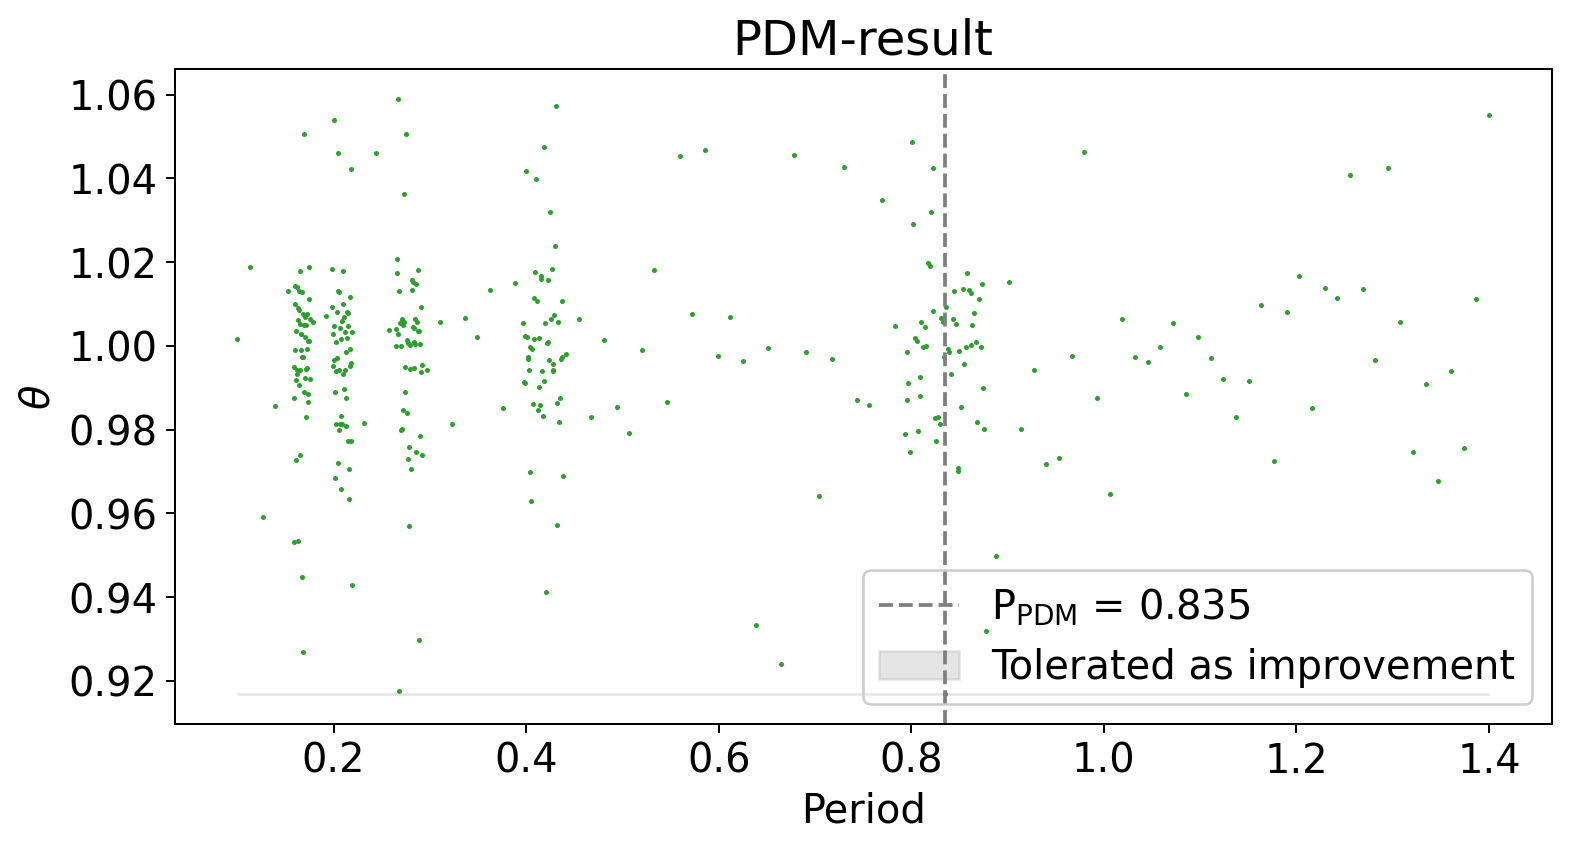

In [16]:
pdm_est = alppe.PDM(
    period_start=0.1, period_stop=1.4, nperiods=100,
    # trial_periods=np.array([0.5, 1, 0.333]),
    n_retries=5,
    tolerance_expression='*1.01',
    tolerance_decay=0.99,
    nperiods_retry=50,
    breakloop=False,
    n_jobs=1,
    verbose=3,
    binning_kwargs={'nintervals':30}
)

print(pdm_est)

pdm_est.fit_predict(x1, y1)
# pdm.fit(x, y)

fig, axs = pdm_est.plot_result()

## Hybrid Period Search (HPS)

Hybrid period finiding algorithm inspired by the one introduced in [Saha et al., 2017](https://ui.adsabs.harvard.edu/abs/2017AJ....154..231S/abstract).

INFO(PDM): generated grid:
    start        = 0.09965429045059865
    stop         = 19.930858090119727
    trial points = (999,)
INFO(PDM): generated grid:
    start        = 0.05017345442320556
    stop         = 10.034690884641112
    trial points = (999,)


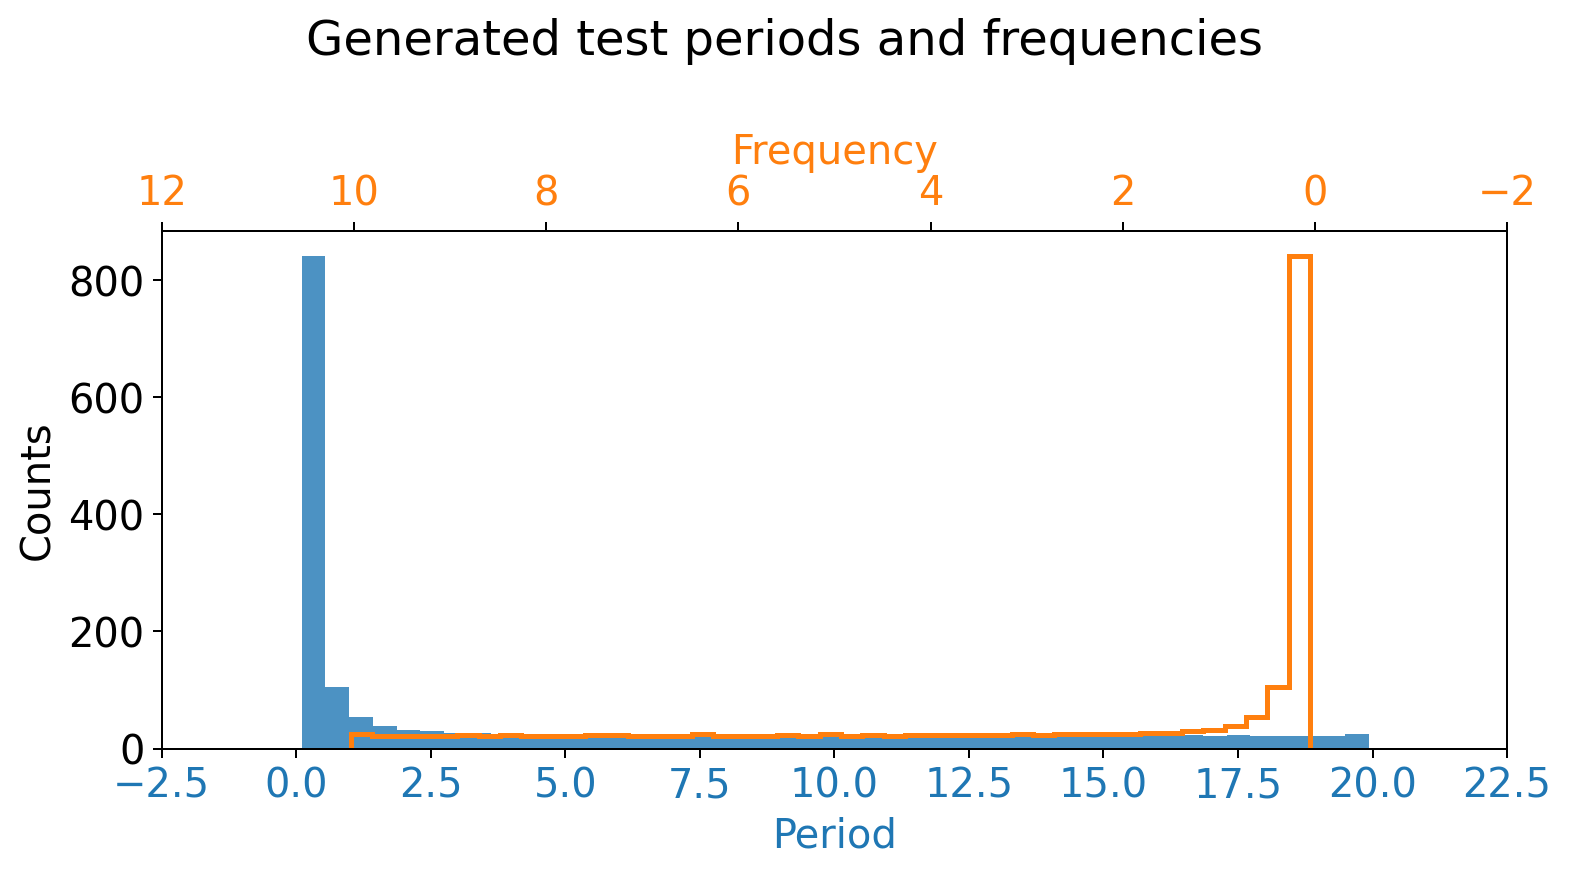

C:\Users\lukas\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\lukas\Documents\GitHub\astroLuSt\demos\..\astroLuSt\preprocessing\binning.py:359: RuntimeWarning: Mean of empty slice
  self.x_binned  = np.append(self.x_binned,  meanfunc_x(self.x[iv_bool]))
c:\Users\lukas\Documents\GitHub\astroLuSt\demos\..\astroLuSt\preprocessing\binning.py:360: RuntimeWarning: Mean of empty slice
  self.y_binned  = np.append(self.y_binned,  meanfunc_y(self.y[iv_bool]))


HPS result:          0.502
PDM result:          4.928
Lomb-Scargle result: 0.502


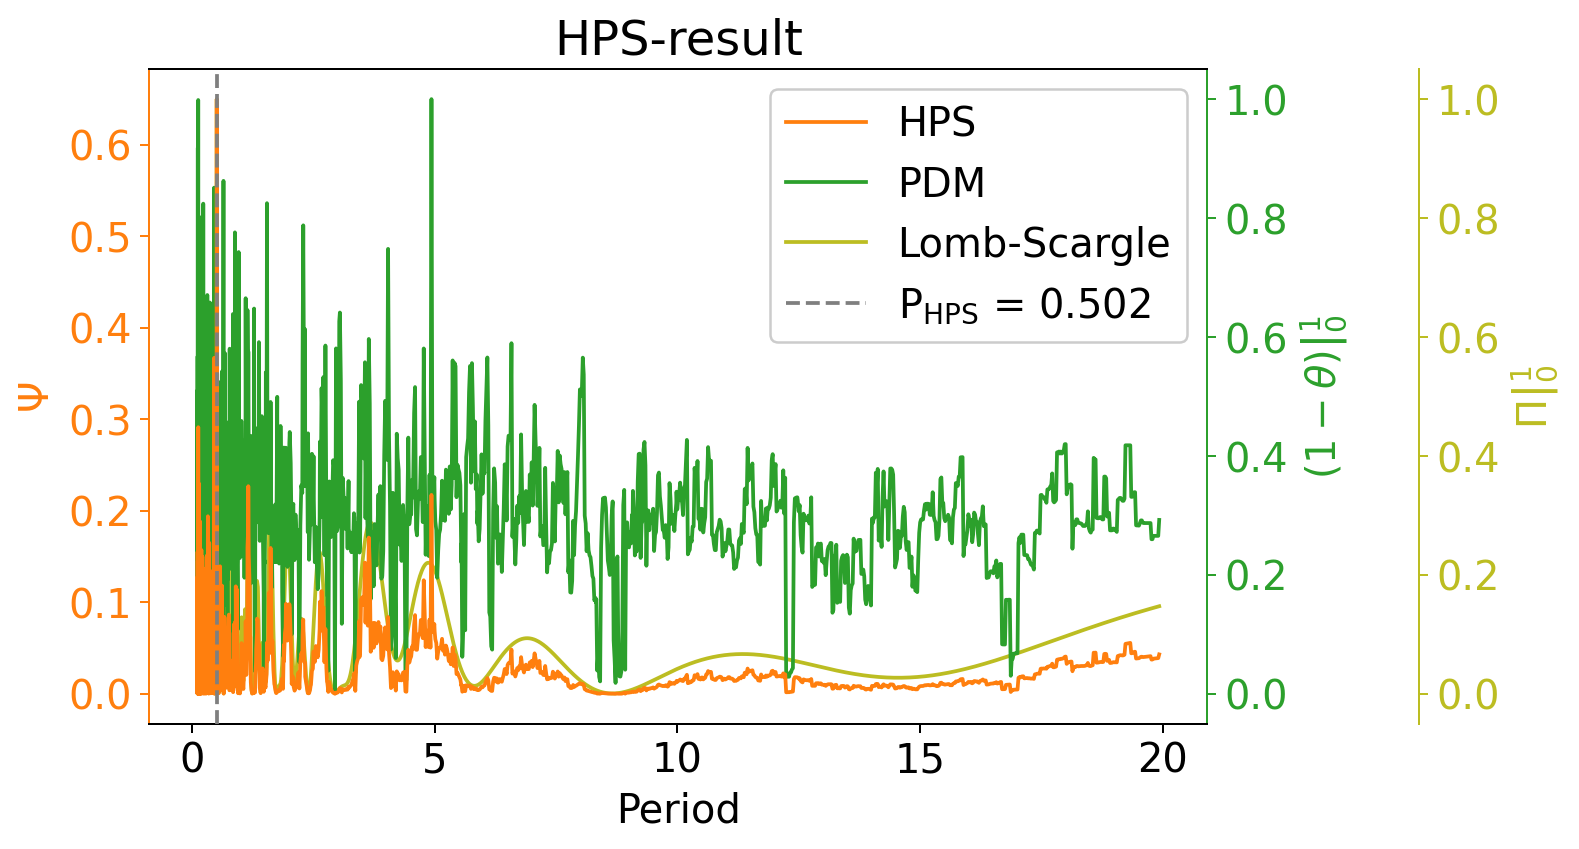

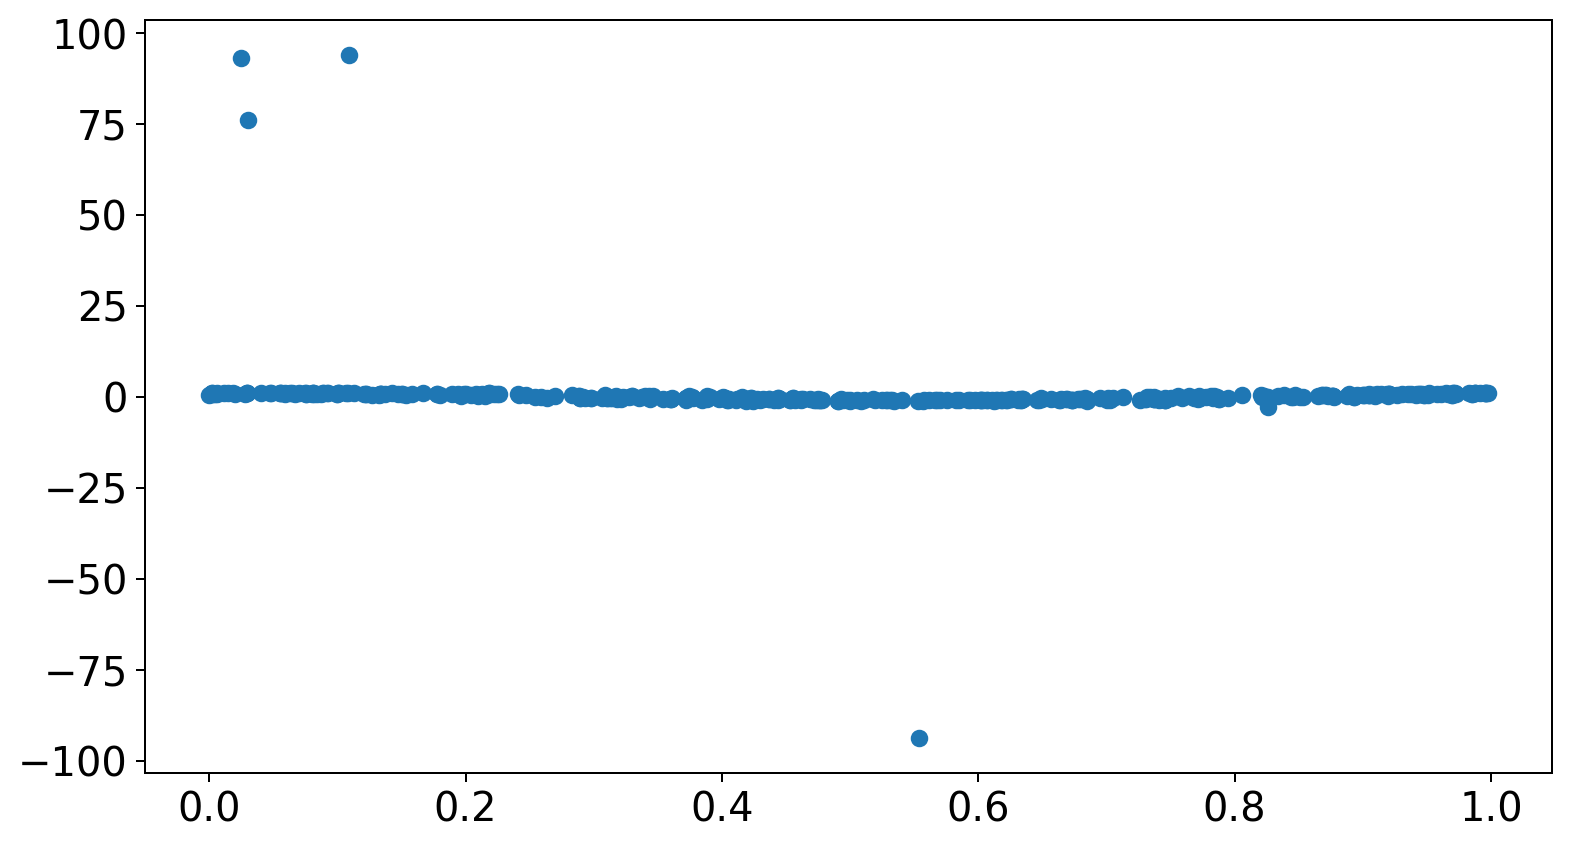

In [22]:
hybps = alppe.HPS(
    # period_start=0.1, period_stop=1.4, nperiods=5000,
    pdm_kwargs={'n_retries':0, 'binning_kwargs':{'nintervals':50}},
    ls_kwargs={'nterms':1},
    verbose=3
)

best_period, best_phi = hybps.fit_predict(x1, y1)
fig, axs = hybps.plot_result(fig_kwargs={'figsize':(9,5)})

print(f'HPS result:          {hybps.best_period:.3f}')
print(f'PDM result:          {hybps.best_period_pdm:.3f}')
print(f'Lomb-Scargle result: {1/hybps.best_frequency_ls:.3f}')

#fold dataseries onto period
ph, pe = alpdm.fold(x1, best_period)
fig = plt.figure()
plt.scatter(ph, y1)
plt.show()

### Passing your own (custom) trial periods

# Sigma Clipping

## Binning to estimate mean curve 

INFO(SigmaClipping): Executing iteration #1/5
INFO(SigmaClipping): Calculating mean-curve because one of 'mean_x', 'mean_y', std_y' is None!
INFO(Binning): Generated 40 bins
INFO(SigmaClipping): stopping_crit evaluated to: 2.23685
INFO(SigmaClipping): Executing iteration #2/5
INFO(SigmaClipping): Calculating mean-curve because one of 'mean_x', 'mean_y', std_y' is None!
INFO(Binning): Generated 40 bins
INFO(SigmaClipping): stopping_crit evaluated to: 0.0905768
INFO(SigmaClipping): stopping_crit fullfilled... Exiting after iteration #2/5


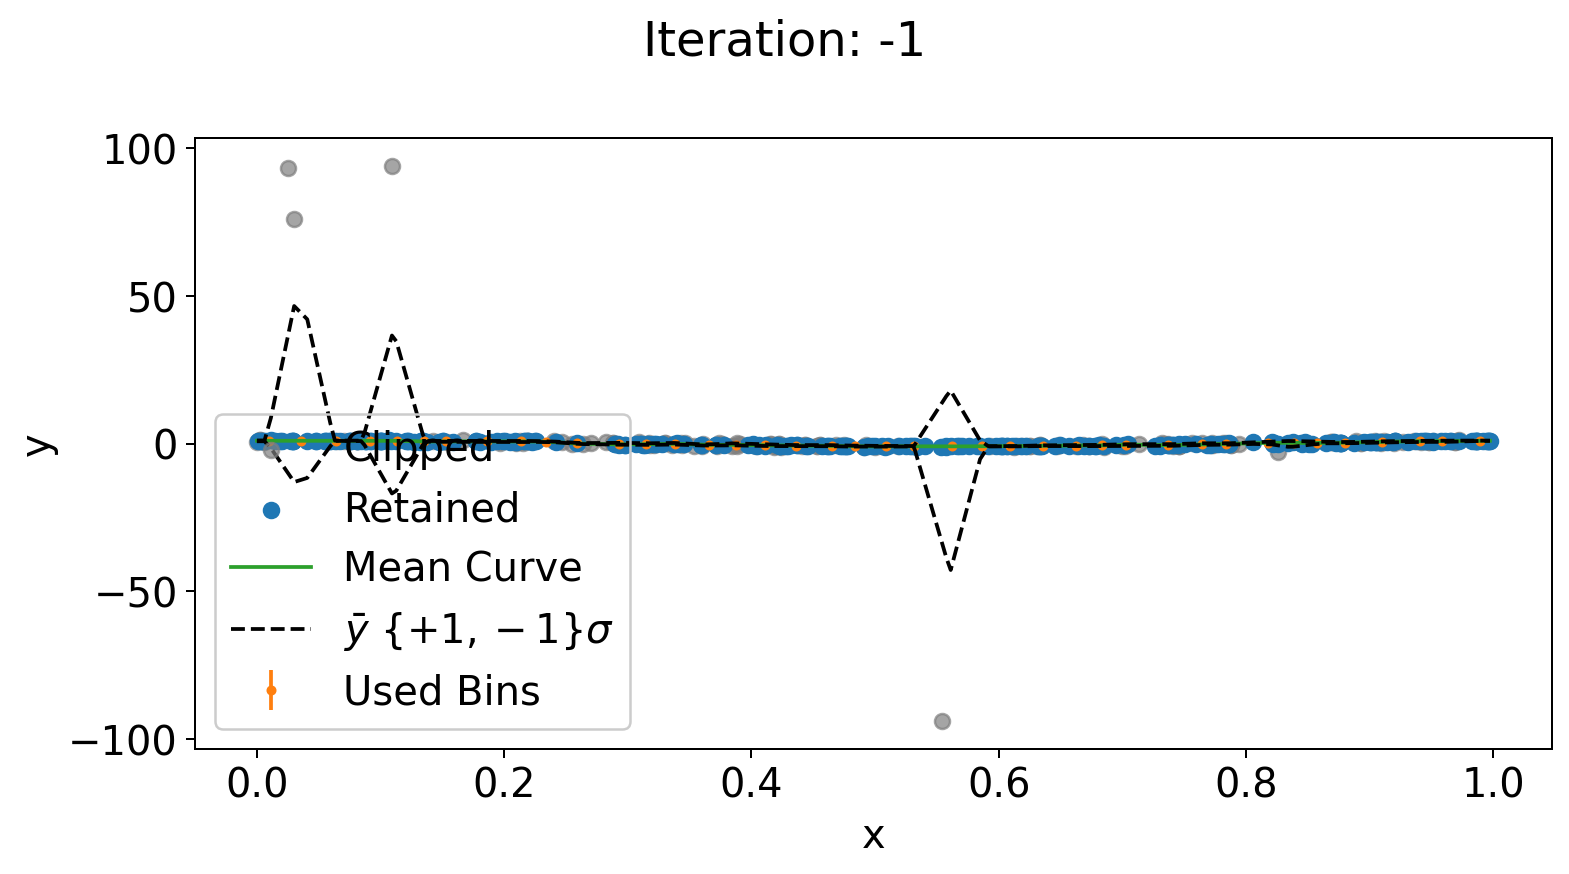

In [23]:

sigclip = alpo.SigmaClipping(
    sigma_bottom=1, sigma_top=1,
    use_polynomial=False,
    use_init_curve_sigma=False,
    bound_history=True, clipmask_history=True,
    verbose=3,
    binning_kwargs={'nintervals':0.1, 'ddof':0}
)


sigclip.fit(
    ph, y1,
    mean_x=None, mean_y=None, std_y=None,
    n_iter=5, stopping_crit='np.nanmean(self.y_std_interp) < 0.4',
)

#plot for last iteration
fig, axs = sigclip.plot_result(show_cut=True, iteration=-1)

ph_clipped, y_clipped = sigclip.transform(ph, y1)

# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# ax1.scatter(ph_clipped, y_clipped)
# plt.show()

## Polynomial to estimate mean curve 

INFO(SigmaClipping): Executing iteration #1/5
INFO(SigmaClipping): Calculating mean-curve because one of 'mean_x', 'mean_y', std_y' is None!
INFO(SigmaClipping): stopping_crit evaluated to: 0.99
INFO(SigmaClipping): Executing iteration #2/5
INFO(SigmaClipping): Calculating mean-curve because one of 'mean_x', 'mean_y', std_y' is None!
INFO(SigmaClipping): stopping_crit evaluated to: 0.9875
INFO(SigmaClipping): Executing iteration #3/5
INFO(SigmaClipping): Calculating mean-curve because one of 'mean_x', 'mean_y', std_y' is None!
INFO(SigmaClipping): stopping_crit evaluated to: 0.9875
INFO(SigmaClipping): Executing iteration #4/5
INFO(SigmaClipping): Calculating mean-curve because one of 'mean_x', 'mean_y', std_y' is None!
INFO(SigmaClipping): stopping_crit evaluated to: 0.9875
INFO(SigmaClipping): Executing iteration #5/5
INFO(SigmaClipping): Calculating mean-curve because one of 'mean_x', 'mean_y', std_y' is None!
INFO(SigmaClipping): stopping_crit evaluated to: 0.9875


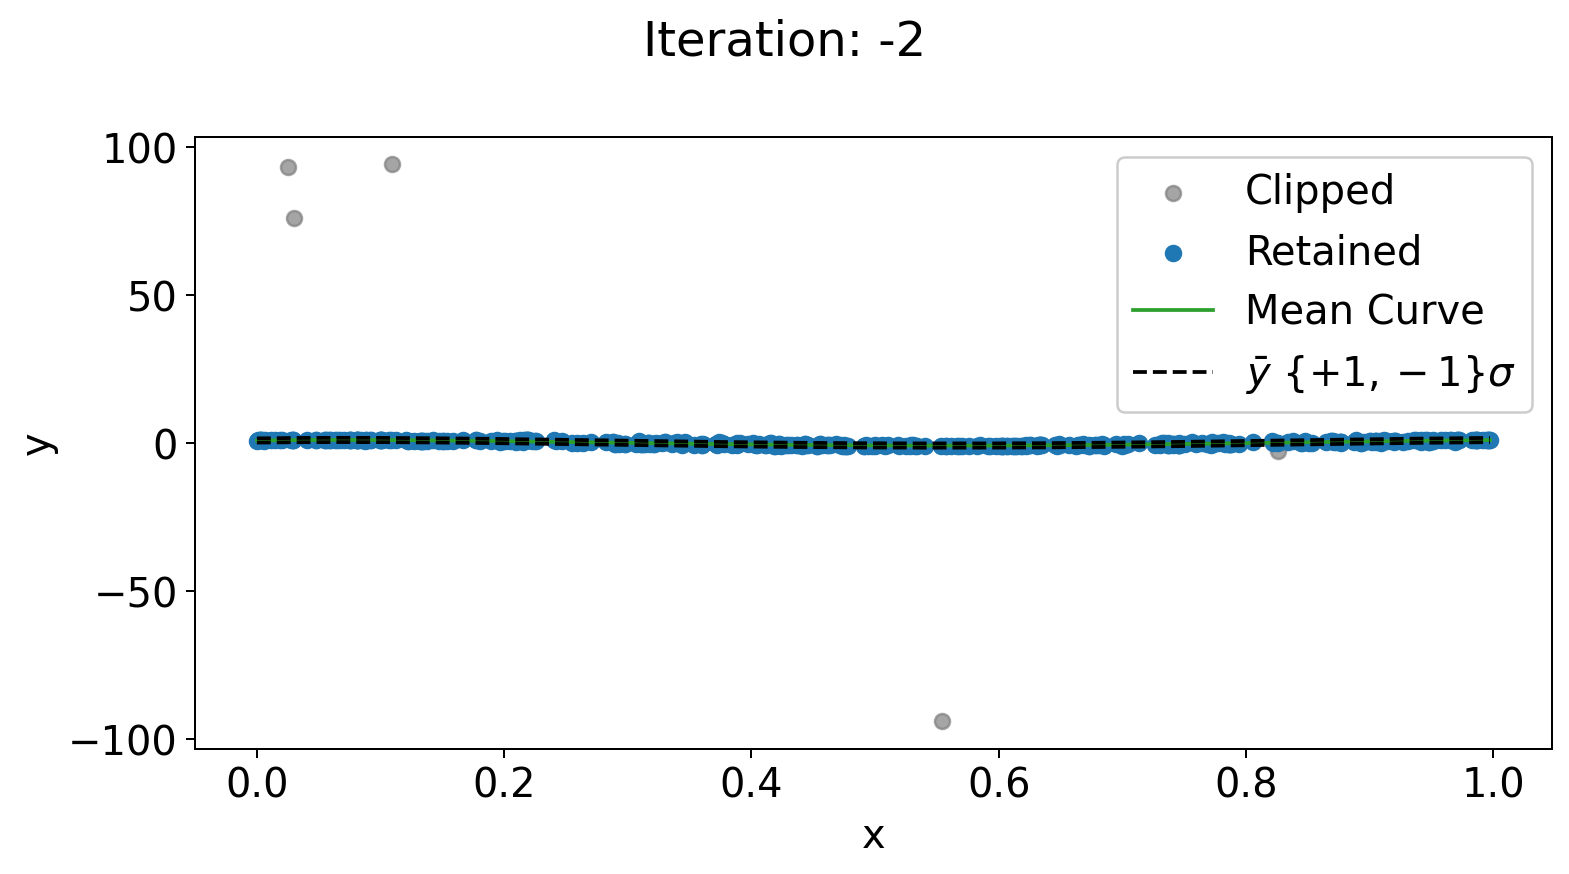

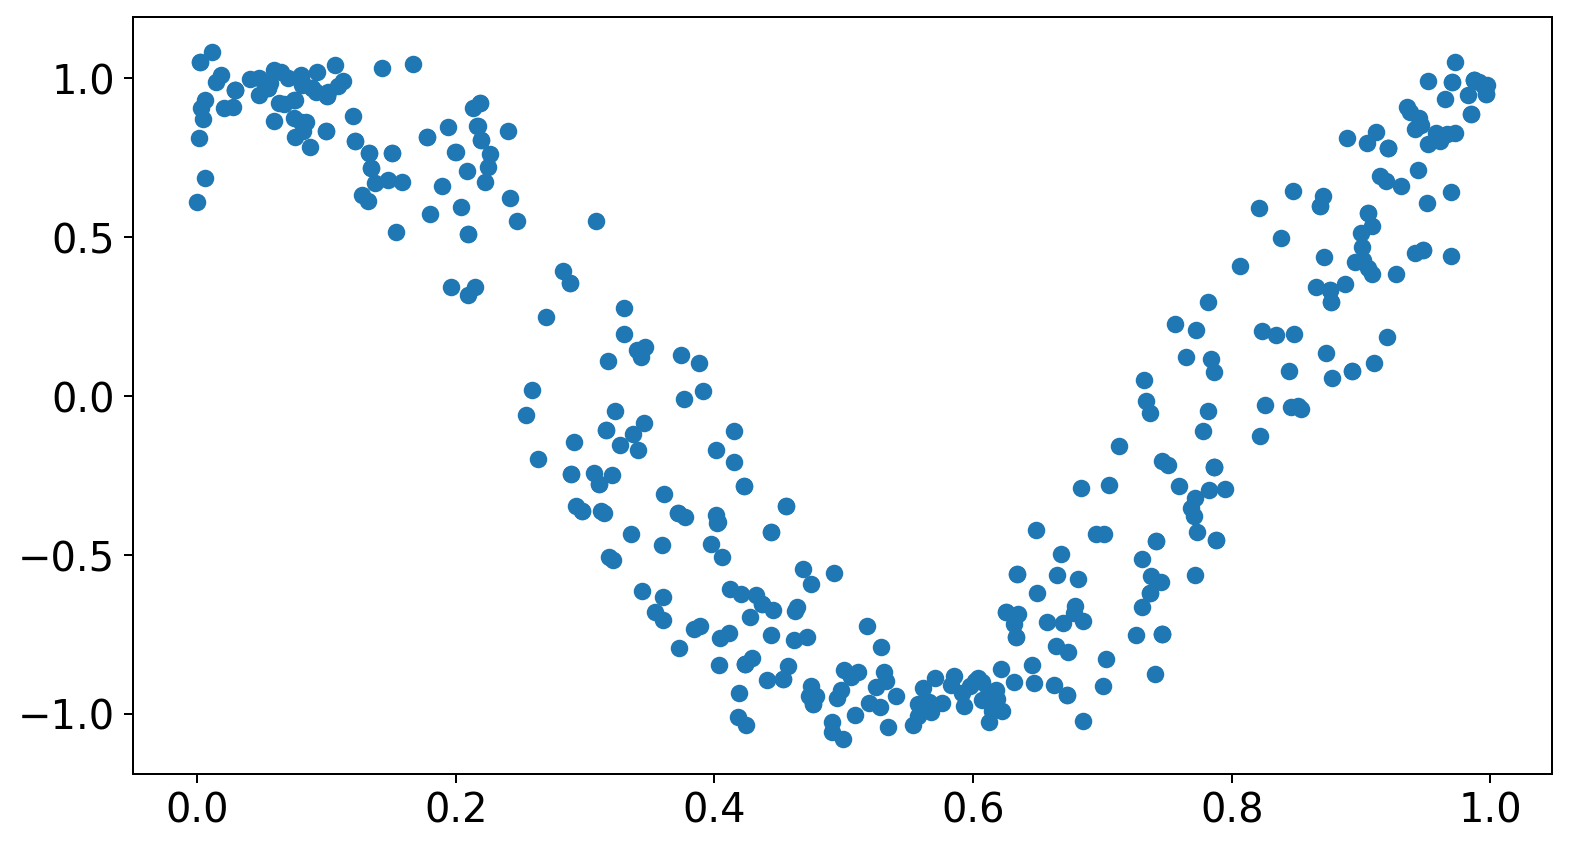

In [24]:
# importlib.reload(sigmaclipping)
sigclip = alpo.SigmaClipping(
    sigma_bottom=1, sigma_top=1,
    use_polynomial=True,
    use_init_curve_sigma=False,
    bound_history=True, clipmask_history=True,
    verbose=3,
)


sigclip.fit(
    ph, y1,
    mean_x=None, mean_y=None, std_y=None,
    n_iter=5, stopping_crit='self.clip_mask.sum()/self.x.shape < 0.7',
    clip_curve_kwargs={'legfit_kwargs':{'deg':4}}
)

#plot for first iteration
fig, axs = sigclip.plot_result(show_cut=True, iteration=-2)

ph_clipped, y_clipped = sigclip.transform(ph, y1)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(ph_clipped, y_clipped)
plt.show()

# Data Binning

## Fixed number of bins

INFO(Binning): Generated 20 bins


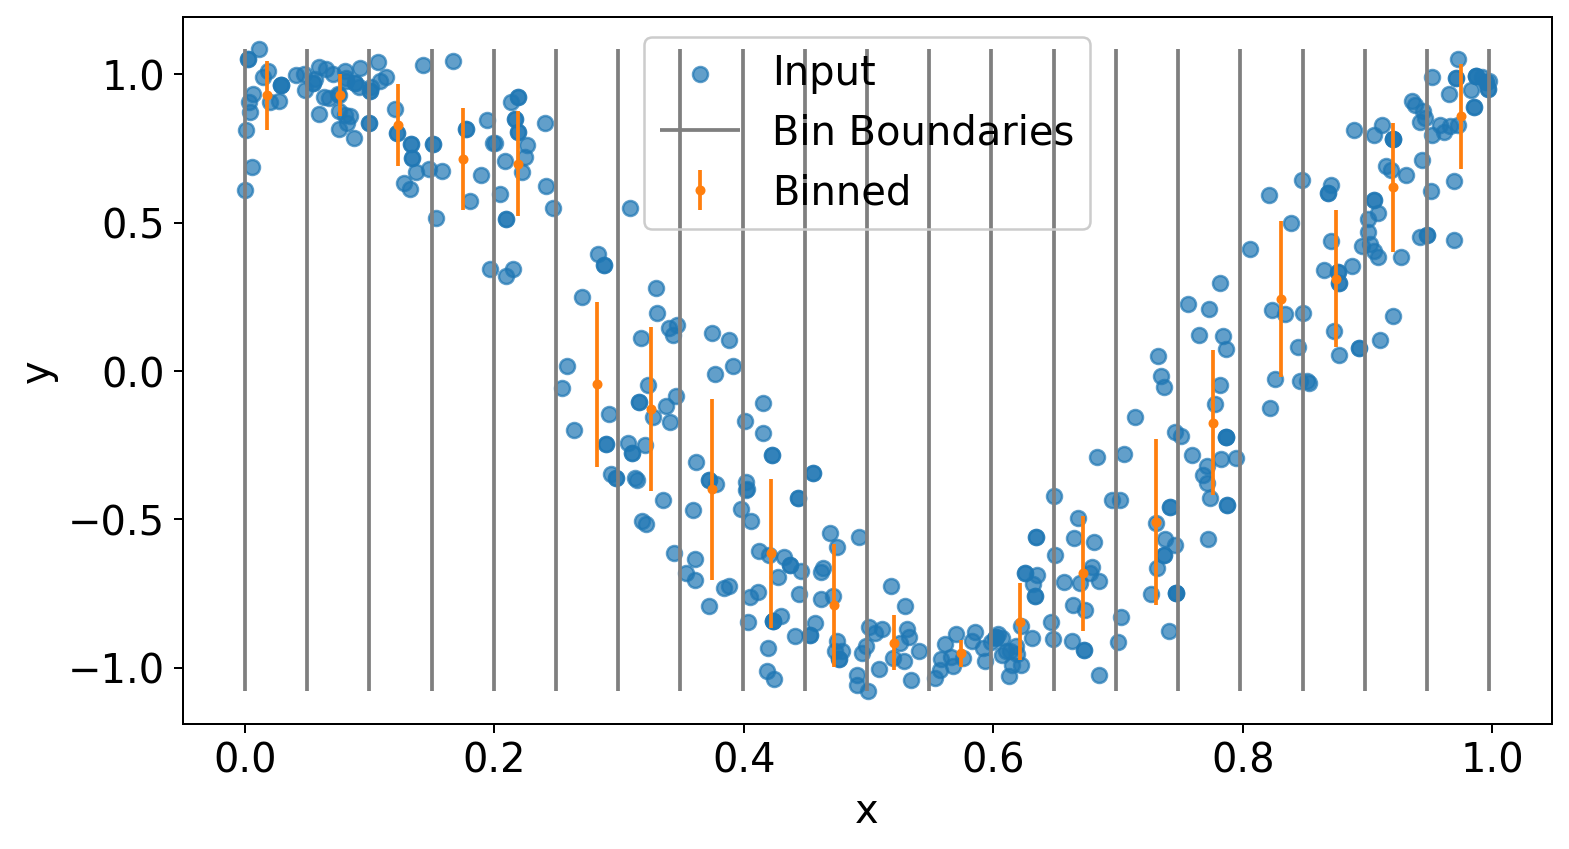

In [25]:
bng = alpo.Binning(
    nintervals=20, npoints_per_interval=None,
    xmin=None, xmax=None,
    ddof=0,
    verbose=3
)

x_binned, y_binned, y_std = bng.fit_transform(ph_clipped, y_clipped)

fig, axs = bng.plot_result()

## Fixed number of bins (fraction of dataseries length)

INFO(Binning): Generated 39 bins


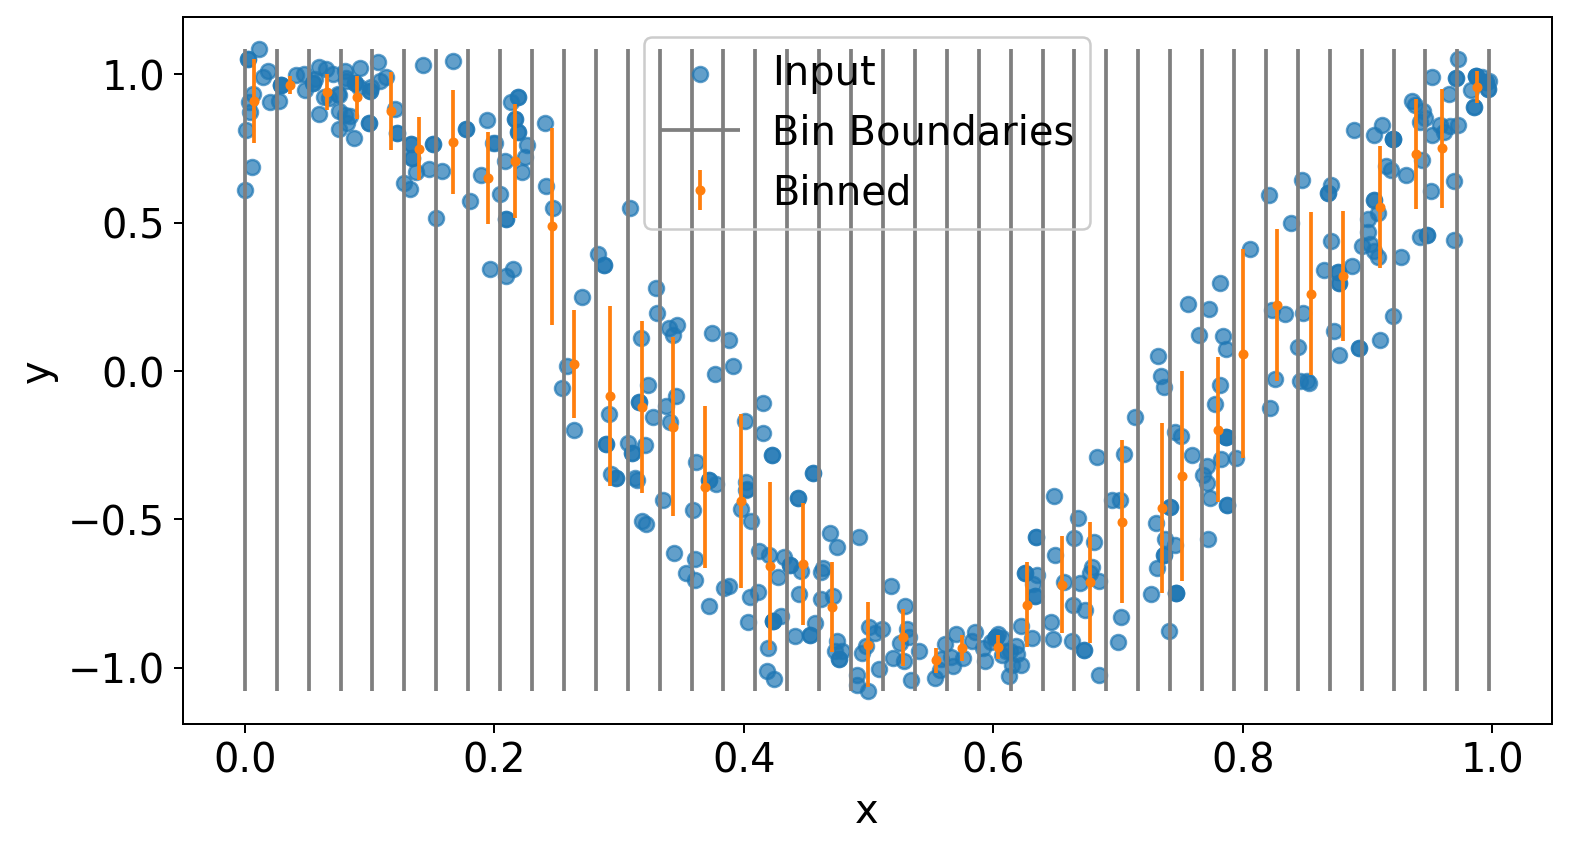

In [26]:
bng = alpo.Binning(
    nintervals=0.1, npoints_per_interval=None,
    xmin=None, xmax=None,
    ddof=0,
    verbose=3
)

x_binned, y_binned, y_std = bng.fit_transform(ph_clipped, y_clipped)

fig, axs = bng.plot_result()

## Fixed number of datapoints per bin

INFO(Binning): Generated 14 bins


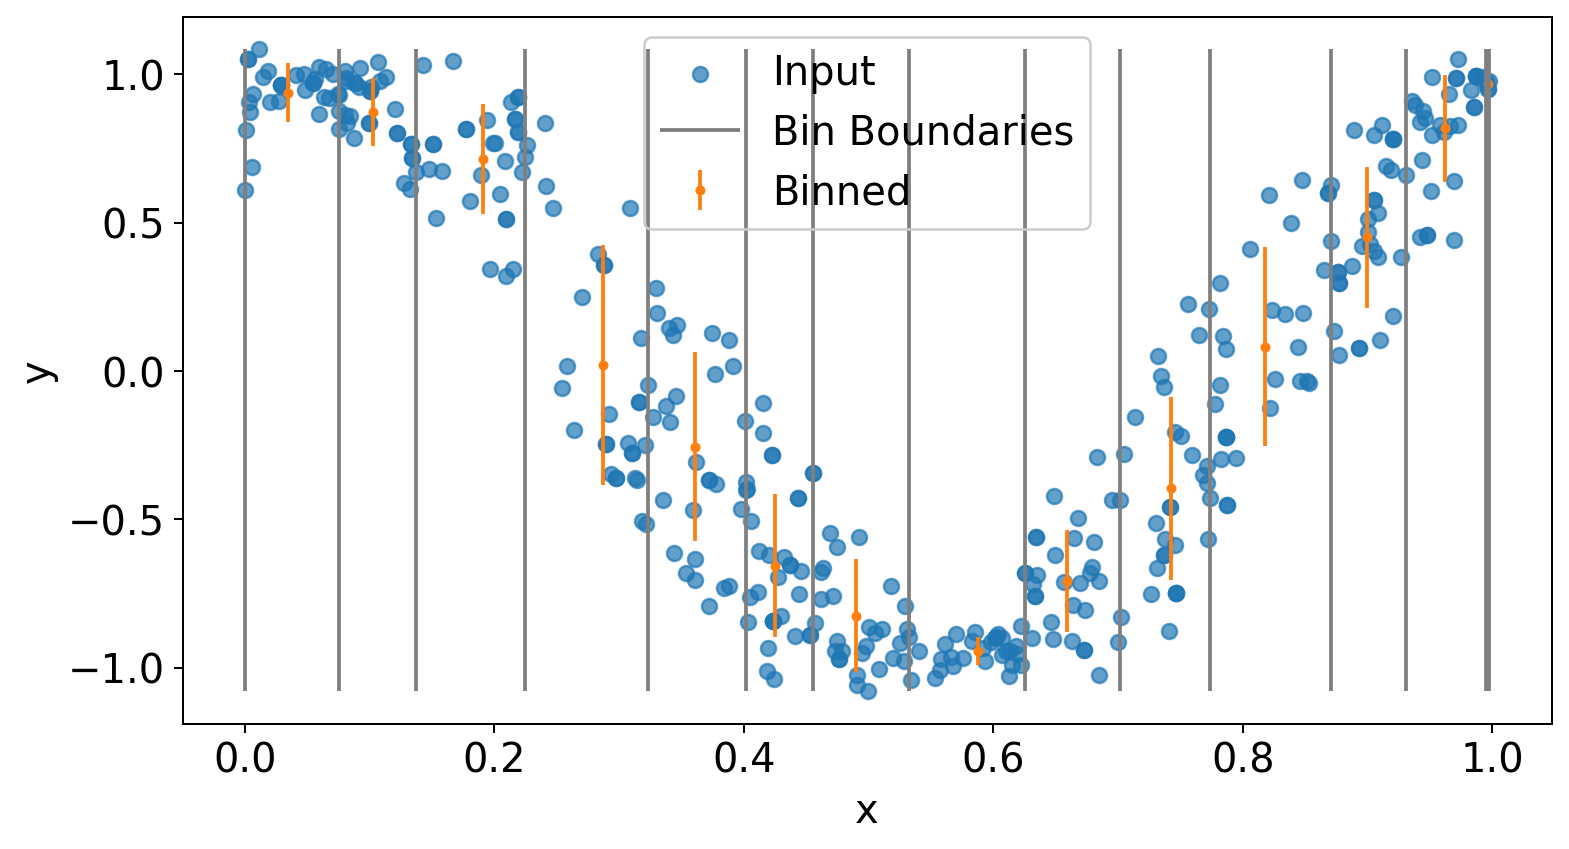

In [27]:
bng = alpo.Binning(
    nintervals=5, npoints_per_interval=30,
    xmin=None, xmax=None,
    ddof=0,
    verbose=3
)

x_binned, y_binned, y_std = bng.fit_transform(ph_clipped, y_clipped)

fig, axs = bng.plot_result()

# Determining The Best Aperture

Generate a TPF timeseries

Shape of generated frames: (10, 15, 15, 3)


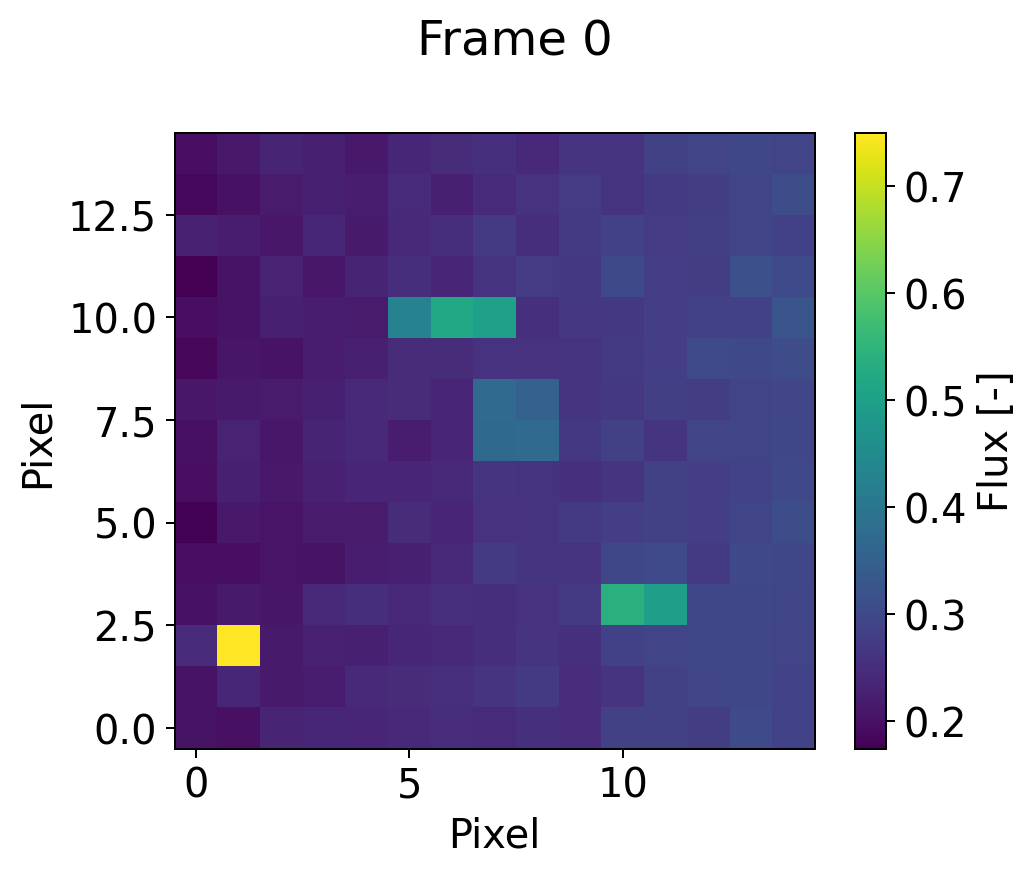

In [44]:

TPFS = alsi.TPF_Series(
    size=15,
    # mode='mag',
    mode='flux',
    rng=None,
    verbose=0,
)

times = np.linspace(0,10,10)

#one fixed star, 4 random stars
frames, starparams_s = TPFS.rvs(
    times=times,
    variability=None,
    add_stars_kwargs=dict(
        nstars  =5,
        posx    =np.append([7.5], np.random.uniform(0,  15, (4))),
        posy    =np.append([7.5], np.random.uniform(0,  15, (4))),
        f       =np.append([1],   np.random.uniform(0.1, 1, (4))),
        m       =np.append([-2.5],np.random.uniform(-2,  0, (4))),
        aperture=np.append([1],   np.random.uniform(1,   2, (4))),
    ),
    add_noise_kwargs=dict(amplitude=1, bias=1E-1),
    add_custom_kwargs=dict(trend='linearx', amplitude=1E-1),
)

fig, axs, anim = TPFS.plot_result()

print(f'Shape of generated frames: {frames.shape}')


BestAperture(
mode='mag'),
store_ring_mask=True),
store_aperture_masks=True),
verbose=0,
)


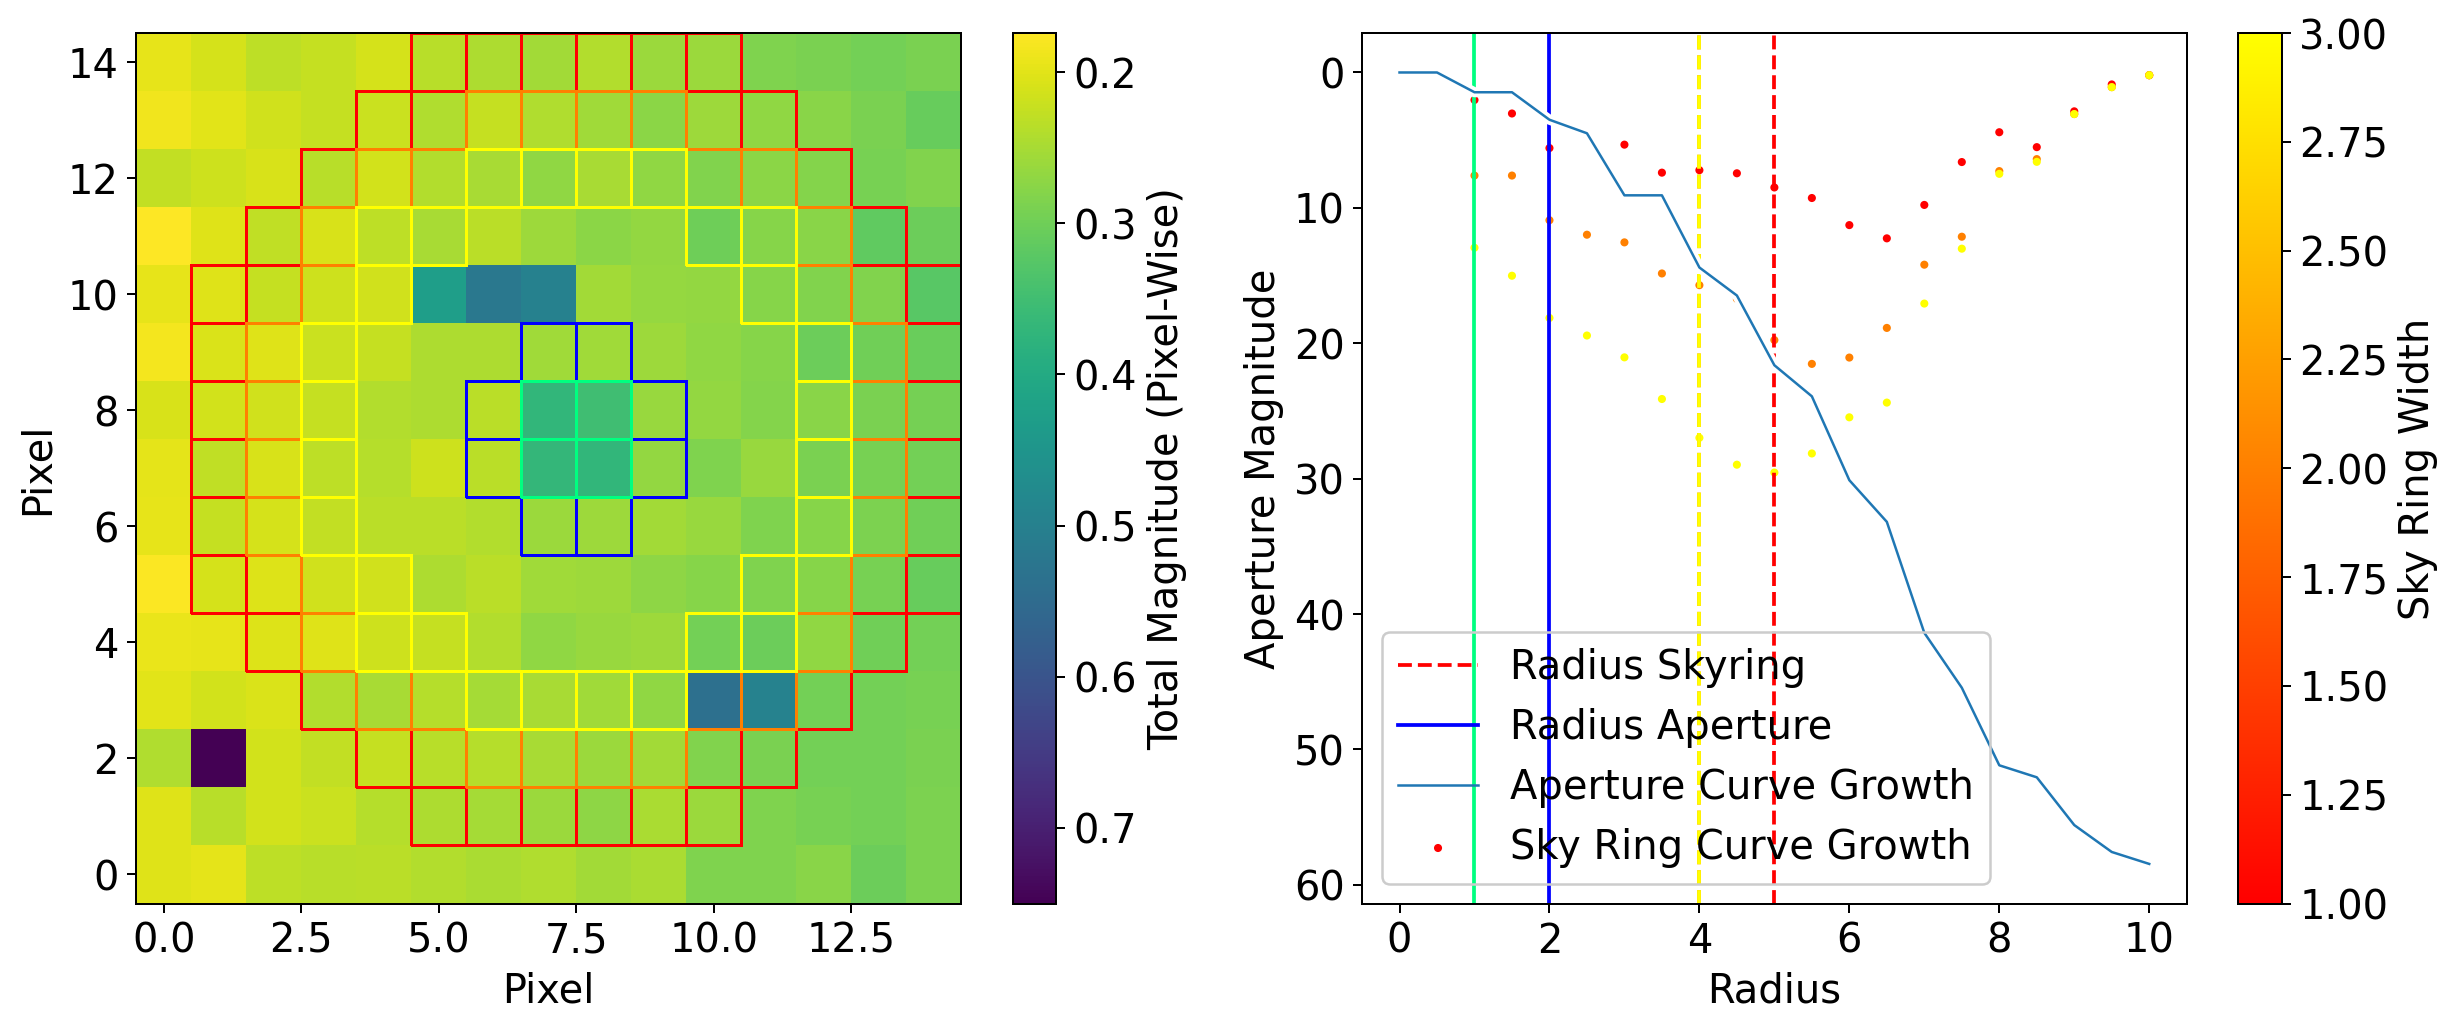

In [48]:
importlib.reload(alpph)
importlib.reload(alsi)

#test radii of aperture and skyring
r_star = np.linspace(0,10,21)
rw_sky = [[i, j] for i in np.linspace(1,10,19) for j in np.linspace(1,3,3)]
# for rw in rw_sky: print(rw)

#instatiate new estimator
BA = alpph.BestAperture(
    # mode='flux',
    mode='mag',
)
print(BA)


BA.fit(
    x=frames[0],
    posx=7.5, posy=7.5,
    # posx=3, posy=3,
    r_aperture=r_star,
    rw_sky=rw_sky
    # r_sky=r_sky,
    # w_sky=w_sky,
)

# BA.predict()

# BA.fit_predict(
#     frames=frames,
#     posx=7.5, posy=7.5,
#     # posx=3, posy=3,
#     r_aperture=r_star,
#     r_sky=r_sky,
#     w_sky=w_sky,
# )

fig, axs = BA.plot_result(
    plot_aperture_r=np.array([1,2]),
    plot_sky_rings_rw=np.array([[4,2],[4,1],[5,2]]),
    sort_rings_apertures=True,
)
